In [1]:
import os
import sys

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [2]:
from src.spinfoam.spinfoams import SingleVertexSpinFoam
from src.spinfoam.sf_env import SpinFoamEnvironment

spin_j = 3.0
env = SpinFoamEnvironment(
    spinfoam_model=SingleVertexSpinFoam(spin_j=spin_j)
)

In [3]:
import torch

from gfn import LogitPBEstimator, LogitPFEstimator, LogZEstimator
from gfn.losses import TBParametrization, TrajectoryBalance
from gfn.samplers import DiscreteActionsSampler, TrajectoriesSampler

logit_PF = LogitPFEstimator(env=env, module_name="NeuralNet")
logit_PB = LogitPBEstimator(
    env=env,
    module_name="NeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))


training_sampler = TrajectoriesSampler(
    env=env,
    actions_sampler=DiscreteActionsSampler(
        estimator=logit_PF,
        epsilon=0.5
    )
)

eval_sampler = TrajectoriesSampler(
    env=env, actions_sampler=DiscreteActionsSampler(estimator=logit_PF)
)

parametrization = TBParametrization(logit_PF, logit_PB, logZ)
loss_fn = TrajectoryBalance(
    parametrization=parametrization,
    log_reward_clip_min=-500.0
)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if "logZ" not in key
        ],
        "lr": 0.001,
    },
#     {"params": [val for key, val in parametrization.parameters.items() if "logZ" in key], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

/home/josephb/anaconda3/envs/gfn/lib/python3.10/site-packages/torch/optim/adam.py:33: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


In [4]:
from tqdm import tqdm

losses = []
terminal_states = []

for i in (pbar := tqdm(range(int(1e3)))):
    trajectories = training_sampler.sample(
        n_trajectories=int(1e3)
    )
    optimizer.zero_grad()
    loss = loss_fn(trajectories)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        pbar.set_postfix({"loss": loss.item()})
        eval_trajectories = eval_sampler.sample(
            n_trajectories=int(1e3)
        )
        terminal_states.append(
            eval_trajectories.last_states.states_tensor[None, :, :]
        )
       
    losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.40it/s, loss=0.832]


In [7]:
intertwiners = torch.cat(terminal_states)
cos_angles = intertwiners*(intertwiners+1)/(2*spin_j*(spin_j+1)) - 1
ave_cos_angles = torch.mean(cos_angles, dim=1)
ave_cos_angles

tensor([[-0.8116, -0.8272, -0.8230, -0.8173, -0.8128],
        [-0.5792, -0.5837, -0.5411, -0.5479, -0.5428],
        [-0.4753, -0.7593, -0.7272, -0.6062, -0.6958],
        [-0.4867, -0.8484, -0.8021, -0.6712, -0.7760],
        [-0.3843, -0.8301, -0.6693, -0.6708, -0.6884],
        [-0.3102, -0.8377, -0.6926, -0.6573, -0.7682],
        [-0.4247, -0.8547, -0.7750, -0.7644, -0.7654],
        [-0.4325, -0.8472, -0.7480, -0.6971, -0.7758],
        [-0.6122, -0.8224, -0.7842, -0.6890, -0.7646],
        [-0.4390, -0.8064, -0.7663, -0.6342, -0.7394]])

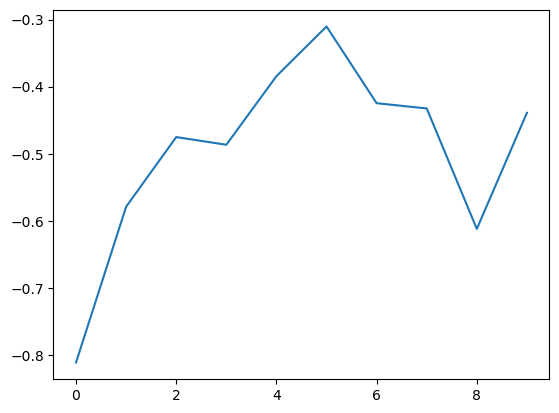

In [8]:
import matplotlib.pyplot as plt

plt.plot(ave_cos_angles[:, 0])